In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 598.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import tensorflow as tf

# Indonesian Rupiah Currency Classification

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Melakukan set model untuk mengatur lebar, tinggi gambar, epoch dll dengan membuat kelas config

In [55]:
class Config:
    img_height = 200
    img_width = 200
    epochs = 20
    batch_size = 32
    learning_rate = 1e-3

2. Memanggil directory dataset yang digunakan

In [56]:
dir_path = '/content/drive/MyDrive/Uang baru'
image_paths = []

for dirname, _, filenames in os.walk(dir_path):
    for filename in filenames:
        image_path  = os.path.join(dirname, filename)
        image_paths.append(image_path)

3. Melakukan pengambilan filename dan nominal berdasarkan path yang digunakan



In [57]:
df = pd.DataFrame({
    'path': image_paths
})

df['filename'] = df.path.apply(lambda x: x.split('/')[5])
df['nominal'] = df.path.apply(lambda x: x.split('/')[-1])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,path,filename,nominal
0,/content/drive/MyDrive/Uang baru/10000/IMG_341...,10000,IMG_3418.jpg
1,/content/drive/MyDrive/Uang baru/5000 P/IMG-20...,5000 P,IMG-20240813-WA0275.jpg
2,/content/drive/MyDrive/Uang baru/20000/IMG-202...,20000,IMG-20240813-WA0076.jpg
3,/content/drive/MyDrive/Uang baru/100000/100_3....,100000,100_3.2.jpg
4,/content/drive/MyDrive/Uang baru/100000/100_10...,100000,100_10.1.jpg


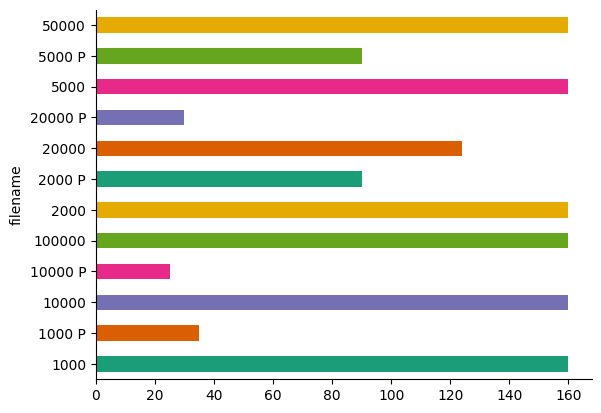

In [58]:
# @title filename

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('filename').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

4. Melakukan plot pada baru untuk mengecek filename

<BarContainer object of 12 artists>

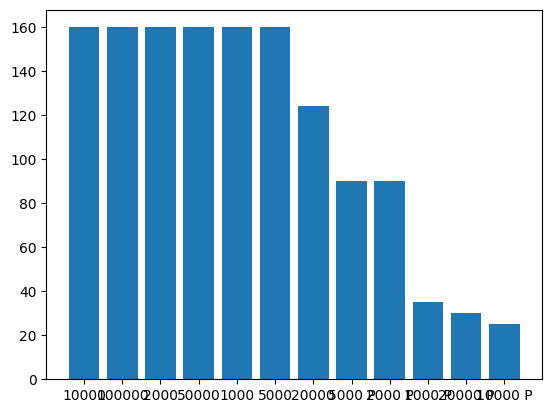

In [59]:
filename_vc = df.filename.value_counts()
plt.bar(filename_vc.index, filename_vc.values)

5. Memuat dataset gambar untuk pelatihan model TensorFlow dengan melakukan pengaturan subset training, validasi, ukuran gambar, batch size, dan pengacakan data.

In [60]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=10
)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset='training',
    validation_split=0.2,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=Config.batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset='validation',
    validation_split=0.2,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=Config.batch_size
)

Found 1354 files belonging to 12 classes.
Found 1354 files belonging to 12 classes.
Using 1084 files for training.
Found 1354 files belonging to 12 classes.
Using 270 files for validation.


6. Label

In [61]:
currency_nominal = dataset.class_names
num_of_classes = len(currency_nominal)
currency_nominal

['1000',
 '1000 P',
 '10000',
 '10000 P',
 '100000',
 '2000',
 '2000 P',
 '20000',
 '20000 P',
 '5000',
 '5000 P',
 '50000']

7. Menampilkan Gambar dan Label

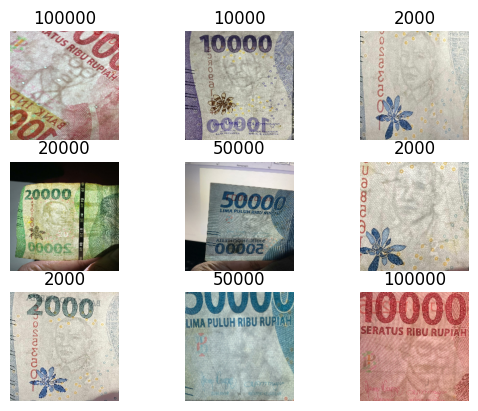

In [62]:
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(currency_nominal[labels[i]])
        plt.axis('off')

9. Menghasilkan variasi data yang lebih banyak dan lebih beragam dari dataset gambar

In [63]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                               input_shape=(
                                   Config.img_height,
                                   Config.img_width,
                                   3)
                              ),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10. Membangun model CNN dengan beberapa layer dan melakuakn pooling serta flatteing

In [64]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_of_classes)
])

11. Melakukan konfigurasi model seperti optimizer, loss function, dan metrik evaluasi

In [65]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

12. Melatih model dengan data

In [66]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=Config.epochs,
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 190s 6s/step - accuracy: 0.1807 - loss: 2.3259 - val_accuracy: 0.4444 - val_loss: 1.5767
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.5732 - loss: 1.2785 - val_accuracy: 0.7926 - val_loss: 0.6837
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.8181 - loss: 0.6087 - val_accuracy: 0.8148 - val_loss: 0.5043
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.7908 - loss: 0.6271 - val_accuracy: 0.8074 - val_loss: 0.5872
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.9029 - loss: 0.3312 - val_accuracy: 0.9037 - val_loss: 0.2505
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.9166 - loss: 0.2512 - val_accuracy: 0.9444 - val_loss: 0.1304
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.9372 - loss: 0.1823 - val_accuracy: 0.9037 - val_loss: 0.2773
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.9576 - loss: 0.1252 - val_accuracy: 0.9778 - v

13. Melakukan plot pada graph untuk melihat peningkatan accuracy serta loss setiap epoch

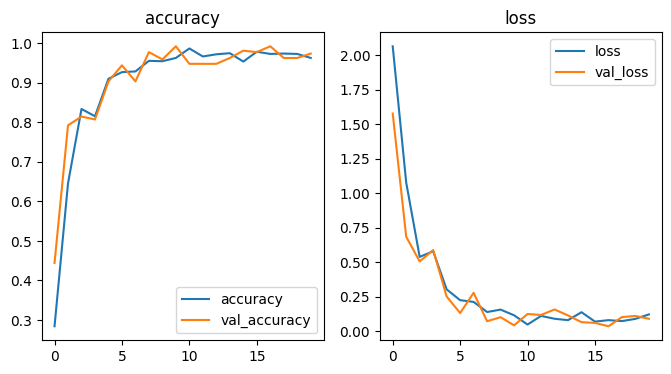

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.set_title('accuracy')
ax1.plot(model.history.history['accuracy'], label='accuracy')
ax1.plot(model.history.history['val_accuracy'], label='val_accuracy')
ax1.legend()

ax2.set_title('loss')
ax2.plot(model.history.history['loss'], label='loss')
ax2.plot(model.history.history['val_loss'], label='val_loss')
ax2.legend()

In [68]:
loss, accuracy = model.evaluate(dataset)
print('accuracy :', accuracy)
print('loss     :', loss)

136/136 ━━━━━━━━━━━━━━━━━━━━ 66s 485ms/step - accuracy: 0.9770 - loss: 0.0706
accuracy : 0.9719350337982178
loss     : 0.08089249581098557


Melakukan plot gambar serta label berdasarkan data random yang diambil untuk mengecek apakah model sudah berjalan dengan baik

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


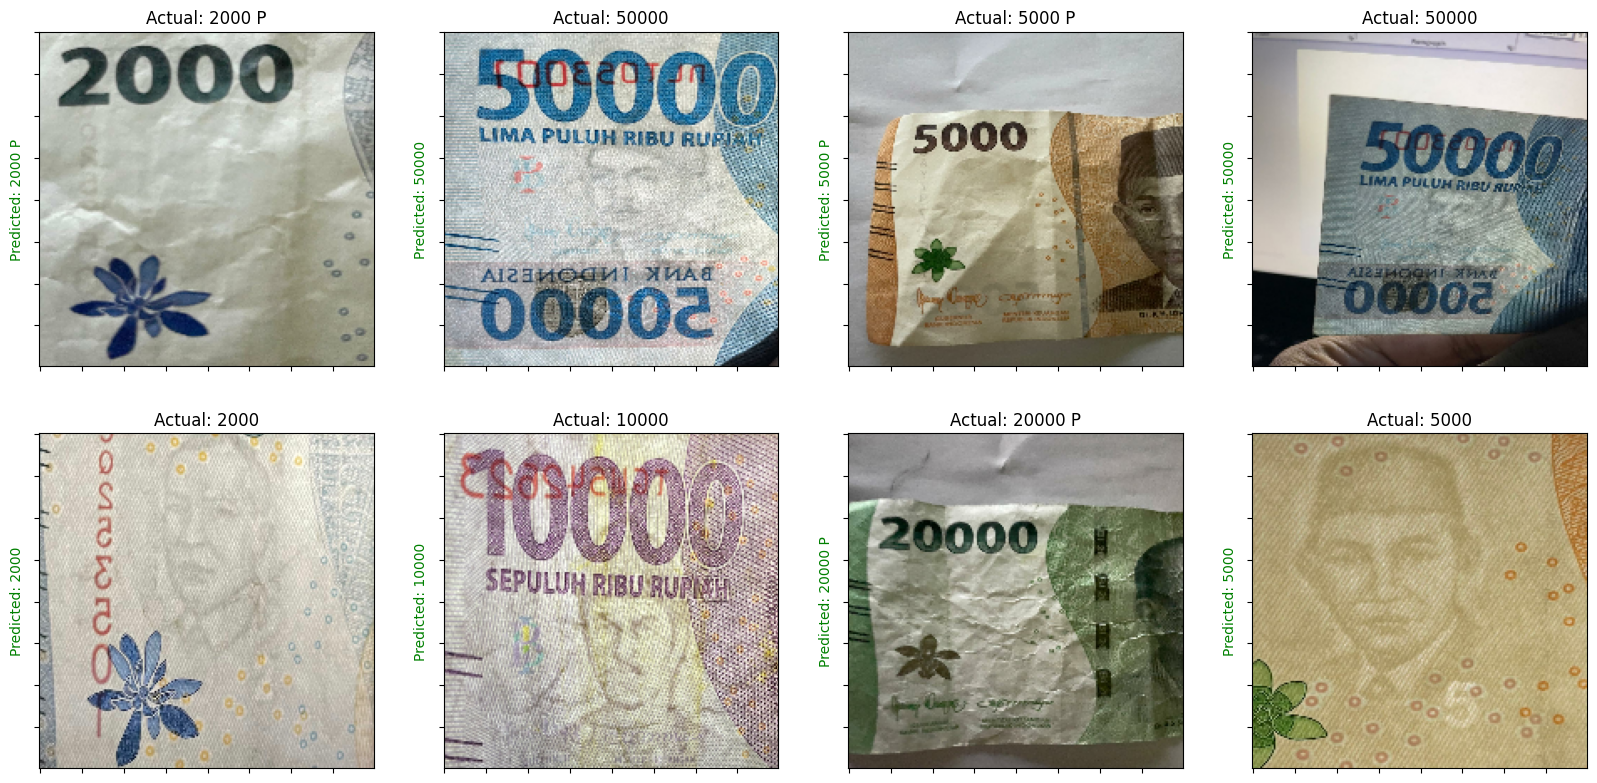

In [69]:
plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])

        predicted_axis_color = 'green' if currency_nominal[labels[i]] == currency_nominal[np.argmax(score)] else 'red'

        plt.title('Actual: ' + currency_nominal[labels[i]])
        plt.ylabel('Predicted: ' + currency_nominal[np.argmax(score)], fontdict={'color': predicted_axis_color})

        plt.gca().axes.xaxis.set_ticklabels([])
        plt.gca().axes.yaxis.set_ticklabels([])

In [70]:
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Calculate accuracy (no 'average' parameter needed)
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision, recall, and F1 score (use 'average' here)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
Accuracy: 0.9740740740740741
Precision: 0.9784216896635198
Recall: 0.9740740740740741
F1 Score: 0.9750790752046233


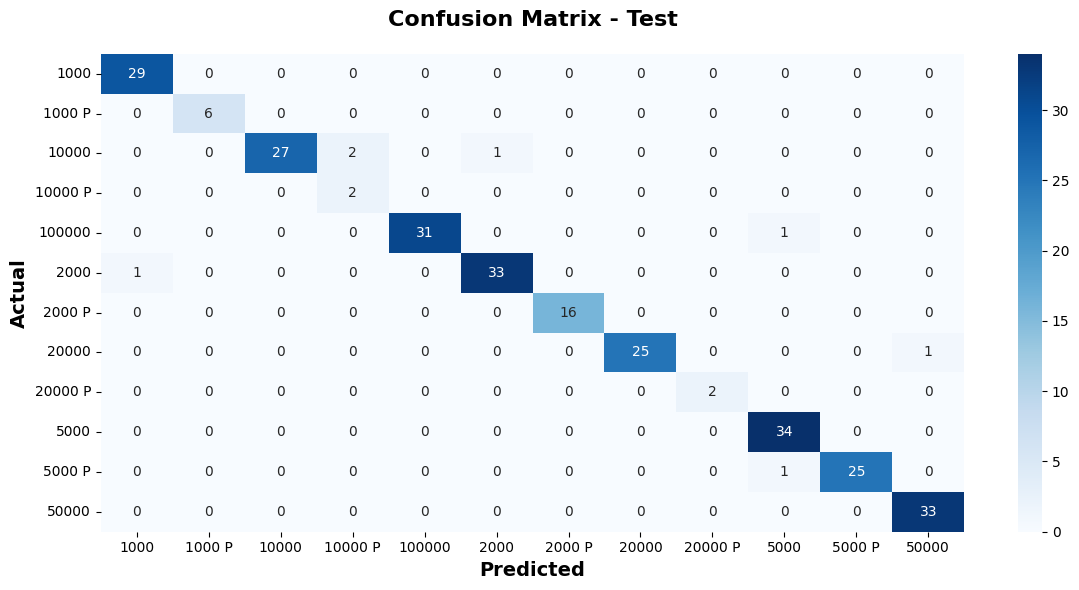

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Label map with your class names
label_map = {
    0: '1000', 1: '1000 P', 2: '10000', 3: '10000 P', 4: '100000',
    5: '2000', 6: '2000 P', 7: '20000', 8: '20000 P', 9: '5000',
    10: '5000 P', 11: '50000'
}

# Assuming y_true and y_pred are already available
# y_true and y_pred should be integer indices corresponding to the class labels in label_map

# Convert your true and predicted labels to the string class names
y_true_mapped = [label_map[i] for i in y_true]
y_pred_mapped = [label_map[i] for i in y_pred]

# Class names extracted from the label map
class_names = list(label_map.values())

# Generate the confusion matrix
CMatrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=class_names)

# Plot confusion matrix
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot=True, fmt='g', cmap='Blues')

# Set ticks in the center of each cell
ax.set_xticks(np.arange(len(class_names)) + 0.5)
ax.set_yticks(np.arange(len(class_names)) + 0.5)

# Set tick labels
ax.set_xticklabels(class_names, rotation=0, ha='center')
ax.set_yticklabels(class_names, rotation=0, va='center')

# Label axes and title
ax.set_xlabel('Predicted', fontdict={'fontsize': 14, 'weight': 'bold'})
ax.set_ylabel('Actual', fontdict={'fontsize': 14, 'weight': 'bold'})
ax.set_title('Confusion Matrix - Test', fontsize=16, weight='bold', pad=20)

plt.tight_layout()
plt.show()


### Save model

In [ ]:
model.save('my_model.keras')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmplc0k33d0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138952397130208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397130560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397136192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397140944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397131968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397479376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397482368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397482544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952397483776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138952395641904: TensorSpec(shape=(), dtype=tf.resource, name=None)
